# Comparaison de LOF, OC-SVM et Isolation Forest

## Jeu de données

Nous utilisons le jeu de données KDD99CUP

## Métriques de comparaison

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from matplotlib.mlab import frange
import statistics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from imblearn.metrics import specificity_score
from imblearn.metrics import sensitivity_score
import matplotlib.cm as cm
from mpl_toolkits import mplot3d

Using TensorFlow backend.


## Chargement du jeu de données KDD99-Cup HTTP

KDD99-Cup HTTP contient 30 attributs dont le dernier est la classe à expliquer.
Il y a 620098 observations dont 1052 anormales.
Avec le dernier attribut, nous avons les classes "o" pour les anomalies et "n" pour les observations normales.

In [2]:
data_brut_KDD99CUP = pd.read_csv('/Users/thesard/Doctorat/These2018/ISEP/Developpements/EspaceIntelliJ/LearningAllInPython/Learning_IHM_Features/datasets/imported_datasets/kdd99-unsupervised-ad_2019-06-24 16:08:29.815617.csv', header=None, index_col=None)
#data_brut_Shuttle = pd.read_csv('/Users/thesard/Doctorat/These2018/ISEP/Developpements/EspaceIntelliJ/LearningAllInPython/Learning_IHM_Features/datasets/imported_datasets/shuttle-unsupervised-ad_2019-06-14 17:33:02.493755.csv', header=None, index_col=None)
X_KDD99CUP = data_brut_KDD99CUP[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13 ,14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]]
y_brut_KDD99CUP = data_brut_KDD99CUP[[29]]
data_brut_KDD99CUP.describe()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
count,620098.000000,620098.000000,6.200980e+05,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000,...,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000
mean,0.627670,280.374673,4.099298e+03,0.005012,0.912428,0.000947,0.000318,0.000013,0.000010,0.005409,...,127.698101,244.485422,0.996744,0.000796,0.074723,0.031820,0.001920,0.001473,0.087651,0.086732
std,53.972528,1509.901935,2.369388e+04,0.098271,0.282671,0.045654,0.017821,0.003592,0.003111,0.073346,...,105.897233,40.458619,0.033137,0.009522,0.185812,0.050689,0.030694,0.028037,0.274777,0.268543
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,210.000000,4.580000e+02,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,22.000000,255.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,240.000000,1.425000e+03,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,96.000000,255.000000,1.000000,0.000000,0.010000,0.020000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,302.000000,3.731000e+03,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,0.050000,0.040000,0.000000,0.000000,0.000000,0.000000
max,41065.000000,54540.000000,1.173059e+07,21.000000,1.000000,21.000000,1.000000,1.000000,1.000000,1.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [3]:
# Nombre d'anomalies
n_outliers = data_brut_KDD99CUP[data_brut_KDD99CUP[29] == 'o']
len(n_outliers)/6

175.33333333333334

In [4]:
#Pourcentage d'anomalies
pourcentage_anomalies = len(n_outliers)/len(data_brut_KDD99CUP)
pourcentage_anomalies

0.0016965060361426743

In [5]:
# Nombre de données normales
n_normals = data_brut_KDD99CUP[data_brut_KDD99CUP[29] == 'n']
len(n_normals)/6

103174.33333333333

In [6]:
#Pourcentage de données normales
pourcentage_normales = len(n_normals)/len(data_brut_KDD99CUP)
pourcentage_normales

0.9983034939638573

In [7]:
# Subset the dataset by myself
import math
n_i_min = 0
o_i_min = 0
n_i_max = math.ceil(len(n_normals)/6)
o_i_max = math.ceil(len(n_outliers)/6)
n_sub_dataset_1 = n_normals[n_i_min:n_i_max]
print("Length normals subset 1 = "+str(len(n_sub_dataset_1)))
o_sub_dataset_1 = n_outliers[o_i_min:o_i_max]
print("Length outliers subset 1 = "+str(len(o_sub_dataset_1)))

n_i_min = n_i_max
o_i_min = o_i_max
n_i_max = n_i_max + math.ceil(len(n_normals)/6)
o_i_max = o_i_max + math.ceil(len(n_outliers)/6)
n_sub_dataset_2 = n_normals[n_i_min:n_i_max]
print("Length normals subset 2 = "+str(len(n_sub_dataset_2)))
o_sub_dataset_2 = n_outliers[o_i_min:o_i_max]
print("Length outliers subset 2 = "+str(len(o_sub_dataset_2)))

n_i_min = n_i_max
o_i_min = o_i_max
n_i_max = n_i_max + math.ceil(len(n_normals)/6)
o_i_max = o_i_max + math.ceil(len(n_outliers)/6)
n_sub_dataset_3 = n_normals[n_i_min:n_i_max]
print("Length normals subset 3 = "+str(len(n_sub_dataset_3)))
o_sub_dataset_3 = n_outliers[o_i_min:o_i_max]
print("Length outliers subset 3 = "+str(len(o_sub_dataset_3)))

n_i_min = n_i_max
o_i_min = o_i_max
n_i_max = n_i_max + math.ceil(len(n_normals)/6)
o_i_max = o_i_max + math.ceil(len(n_outliers)/6)
n_sub_dataset_4 = n_normals[n_i_min:n_i_max]
print("Length normals subset 4 = "+str(len(n_sub_dataset_4)))
o_sub_dataset_4 = n_outliers[o_i_min:o_i_max]
print("Length outliers subset 4 = "+str(len(o_sub_dataset_4)))

n_i_min = n_i_max
o_i_min = o_i_max
n_i_max = n_i_max + math.ceil(len(n_normals)/6)
o_i_max = o_i_max + math.ceil(len(n_outliers)/6)
n_sub_dataset_5 = n_normals[n_i_min:n_i_max]
print("Length normals subset 5 = "+str(len(n_sub_dataset_5)))
o_sub_dataset_5 = n_outliers[o_i_min:o_i_max]
print("Length outliers subset 5 = "+str(len(o_sub_dataset_5)))

n_i_min = n_i_max
o_i_min = o_i_max
n_i_max = n_i_max + math.ceil(len(n_normals)/6)
o_i_max = o_i_max + math.ceil(len(n_outliers)/6)
n_sub_dataset_6 = n_normals[n_i_min:n_i_max]
print("Length normals subset 6 = "+str(len(n_sub_dataset_6)))
o_sub_dataset_6 = n_outliers[o_i_min:o_i_max]
print("Length outliers subset 6 = "+str(len(o_sub_dataset_6)))

Length normals subset 1 = 103175
Length outliers subset 1 = 176
Length normals subset 2 = 103175
Length outliers subset 2 = 176
Length normals subset 3 = 103175
Length outliers subset 3 = 176
Length normals subset 4 = 103175
Length outliers subset 4 = 176
Length normals subset 5 = 103175
Length outliers subset 5 = 176
Length normals subset 6 = 103171
Length outliers subset 6 = 172


## Fusion des deux sub_datasets (normales + anomalies)

In [8]:
# Fusion of the sub_datasets
sub_dataset_1 = n_sub_dataset_1.append(o_sub_dataset_1, ignore_index=True, sort=False)
sub_dataset_2 = n_sub_dataset_2.append(o_sub_dataset_2, ignore_index=True, sort=False)
sub_dataset_3 = n_sub_dataset_3.append(o_sub_dataset_3, ignore_index=True, sort=False)
sub_dataset_4 = n_sub_dataset_4.append(o_sub_dataset_4, ignore_index=True, sort=False)
sub_dataset_5 = n_sub_dataset_5.append(o_sub_dataset_5, ignore_index=True, sort=False)
sub_dataset_6 = n_sub_dataset_6.append(o_sub_dataset_6, ignore_index=True, sort=False)
#Doubler le nombre d'outlier pour voir l'effet sur les méthodes
sub_dataset_1 = sub_dataset_1.append(o_sub_dataset_2, ignore_index=True, sort=False)
#sub_dataset_6.describe()
# Détacher la classe à expliquer des autres classes
X_sub_dataset_1 = sub_dataset_1[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13 ,14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]]
y_sub_dataset_1 = sub_dataset_1[[29]]
X_sub_dataset_2 = sub_dataset_2[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13 ,14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]]
y_sub_dataset_2 = sub_dataset_2[[29]]
X_sub_dataset_3 = sub_dataset_3[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13 ,14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]]
y_sub_dataset_3 = sub_dataset_3[[29]]
X_sub_dataset_4 = sub_dataset_4[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13 ,14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]]
y_sub_dataset_4 = sub_dataset_4[[29]]
X_sub_dataset_5 = sub_dataset_5[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13 ,14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]]
y_sub_dataset_5 = sub_dataset_5[[29]]
X_sub_dataset_6 = sub_dataset_6[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13 ,14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]]
y_sub_dataset_6 = sub_dataset_6[[29]]


## Transformation de la classe à expliquer

L'objectif ici est de remplacer les "o" par -1 et les "n" par 1 afin de faire les matrices de confusion avec la fonction dédiée de scikit-learn.

In [9]:
y_transform_KDD99CUP      = y_brut_KDD99CUP
y_transform_KDD99CUP      = np.where(y_transform_KDD99CUP =='o',-1,1)
#y_transform_KDD99CUP

y_transform_sub_dataset_6 = np.where(y_sub_dataset_6 =='o',-1,1)
y_transform_sub_dataset_5 = np.where(y_sub_dataset_5 =='o',-1,1)
y_transform_sub_dataset_4 = np.where(y_sub_dataset_4 =='o',-1,1)
y_transform_sub_dataset_3 = np.where(y_sub_dataset_3 =='o',-1,1)
y_transform_sub_dataset_2 = np.where(y_sub_dataset_2 =='o',-1,1)
y_transform_sub_dataset_1 = np.where(y_sub_dataset_1 =='o',-1,1)

In [10]:
X_recomposed_shuttle = dict()
X_recomposed_shuttle[0] = X_sub_dataset_1
X_recomposed_shuttle[1] = X_sub_dataset_2
X_recomposed_shuttle[2] = X_sub_dataset_3
X_recomposed_shuttle[3] = X_sub_dataset_4
X_recomposed_shuttle[4] = X_sub_dataset_5
X_recomposed_shuttle[5] = X_sub_dataset_6

Y_recomposed_shuttle = dict()
Y_recomposed_shuttle[0] = y_transform_sub_dataset_1
Y_recomposed_shuttle[1] = y_transform_sub_dataset_2
Y_recomposed_shuttle[2] = y_transform_sub_dataset_3
Y_recomposed_shuttle[3] = y_transform_sub_dataset_4
Y_recomposed_shuttle[4] = y_transform_sub_dataset_5
Y_recomposed_shuttle[5] = y_transform_sub_dataset_6
print(X_recomposed_shuttle)
print("********************************************************************")
print(Y_recomposed_shuttle)

{0:          0      1        2    3    4    5    6    7    8    9   ...     19  \
0       0.0  215.0  45076.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
1       0.0  162.0   4528.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...    1.0   
2       0.0  236.0   1228.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...    2.0   
3       0.0  233.0   2032.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...    3.0   
4       0.0  239.0    486.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...    4.0   
5       0.0  238.0   1282.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...    5.0   
6       0.0  235.0   1337.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...    6.0   
7       0.0  234.0   1364.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...    7.0   
8       0.0  239.0   1295.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...    8.0   
9       0.0  181.0   5450.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...    9.0   
10      0.0  184.0    124.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   10.0   
11      0.0  185.0   9020.0  0.0  1.0  0.0  0.0  0.0  0.0  0

In [11]:
MS_executions_time_IF_Shuttle = []
MS_roc_auc_IF_Shuttle = []
MS_precisions_IF_Shuttle = []
MS_recalls_IF_Shuttle = []
MS_f1_scores_IF_Shuttle = []
MS_tn_IF_Shuttle = []
MS_fp_IF_Shuttle = []
MS_fn_IF_Shuttle = []
MS_tp_IF_Shuttle = []
MS_specificity_IF_Shuttle = []
MS_max_samples_IF_Shuttle = []

X_data = X_recomposed_shuttle[0]
Y_data = Y_recomposed_shuttle[0]

for j in range(0, len(X_recomposed_shuttle), 1):
    if(j > 0):
        #X_data = X_data.append(X_recomposed_shuttle[j], ignore_index=True, sort=False)
        #Y_data = Y_data.append(Y_recomposed_shuttle[j], ignore_index=True, sort=False)
        X_data = np.concatenate((X_data , X_recomposed_shuttle[j]))
        Y_data = np.concatenate((Y_data , Y_recomposed_shuttle[j]))
    MS_max_samples_IF_Shuttle.append(len(X_data))
    print("Taille: ")
    print(MS_max_samples_IF_Shuttle)
    
    start_IF_Shuttle = time()
    
    # Instanciation, fit and predict on Shuttle
    MS_func_IF_Shuttle = IsolationForest(behaviour="new")
    MS_func_IF_Shuttle.fit(X_data)
    MS_y_pred_IF_Shuttle = MS_func_IF_Shuttle.predict(X_data)

    # Calcul du temps d'exécution
    MS_exec_time_IF_Shuttle = time() - start_IF_Shuttle
    MS_executions_time_IF_Shuttle.append(MS_exec_time_IF_Shuttle)
    print("Temps d'exécution: ")
    print(MS_executions_time_IF_Shuttle)
    
    # Precision
    MS_precisions_IF_Shuttle.append(precision_score(Y_data, MS_y_pred_IF_Shuttle))
    print("Precision: ")
    print(MS_precisions_IF_Shuttle)
    
    # Recall
    MS_recalls_IF_Shuttle.append(recall_score(Y_data, MS_y_pred_IF_Shuttle))
    print("Recall: ")
    print(MS_recalls_IF_Shuttle)
    
    # f1_score
    MS_f1_scores_IF_Shuttle.append(f1_score(Y_data, MS_y_pred_IF_Shuttle))
    print("f1_score: ")
    print(MS_f1_scores_IF_Shuttle)
    
    # Specificity
    MS_specificity_IF_Shuttle.append(specificity_score(Y_data, MS_y_pred_IF_Shuttle))
    print("Specificity: ")
    print(MS_specificity_IF_Shuttle)
    
    # Matrice de confusion
    print("Matrice de confusion: ")
    print(confusion_matrix(Y_data, MS_y_pred_IF_Shuttle))
    ttn, tfp, tfn, ttp = confusion_matrix(Y_data, MS_y_pred_IF_Shuttle).ravel()
    tn = ttp
    fp = tfn
    fn = tfp
    tp = ttn
    MS_tn_IF_Shuttle.append(tn)
    MS_fp_IF_Shuttle.append(fp)
    MS_fn_IF_Shuttle.append(fn)
    MS_tp_IF_Shuttle.append(tp)
    
    # Calcul de l'aire sous la courbe ROC
    MS_y_DF_IF_Shuttle = MS_func_IF_Shuttle.decision_function(X_data)
    MS_auc_IF_Shuttle = roc_auc_score(Y_data, MS_y_DF_IF_Shuttle)
    MS_roc_auc_IF_Shuttle.append(MS_auc_IF_Shuttle)
    print("ROC AUC: ")
    print(MS_roc_auc_IF_Shuttle)
    

Taille: 
[103527]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


Temps d'exécution: 
[10.495490789413452]
Precision: 
[1.0]
Recall: 
[0.90306760358614]
f1_score: 
[0.9490651849512857]
Specificity: 
[1.0]
Matrice de confusion: 
[[  352     0]
 [10001 93174]]
ROC AUC: 
[0.9990287353789897]
Taille: 
[103527, 206878]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


Temps d'exécution: 
[10.495490789413452, 21.290433883666992]
Precision: 
[1.0, 1.0]
Recall: 
[0.90306760358614, 0.9023019142234069]
f1_score: 
[0.9490651849512857, 0.9486421765934683]
Specificity: 
[1.0, 1.0]
Matrice de confusion: 
[[   528      0]
 [ 20160 186190]]
ROC AUC: 
[0.9990287353789897, 0.9994209602690338]
Taille: 
[103527, 206878, 310229]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


Temps d'exécution: 
[10.495490789413452, 21.290433883666992, 28.81942319869995]
Precision: 
[1.0, 1.0, 1.0]
Recall: 
[0.90306760358614, 0.9023019142234069, 0.9020466844358291]
f1_score: 
[0.9490651849512857, 0.9486421765934683, 0.9485010981246104]
Specificity: 
[1.0, 1.0, 1.0]
Matrice de confusion: 
[[   704      0]
 [ 30319 279206]]
ROC AUC: 
[0.9990287353789897, 0.9994209602690338, 0.9999414287654836]
Taille: 
[103527, 206878, 310229, 413580]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


Temps d'exécution: 
[10.495490789413452, 21.290433883666992, 28.81942319869995, 39.16515517234802]
Precision: 
[1.0, 1.0, 1.0, 1.0]
Recall: 
[0.90306760358614, 0.9023019142234069, 0.9020466844358291, 0.9019190695420403]
f1_score: 
[0.9490651849512857, 0.9486421765934683, 0.9485010981246104, 0.9484305446910649]
Specificity: 
[1.0, 1.0, 1.0, 1.0]
Matrice de confusion: 
[[   880      0]
 [ 40478 372222]]
ROC AUC: 
[0.9990287353789897, 0.9994209602690338, 0.9999414287654836, 0.9926785332731237]
Taille: 
[103527, 206878, 310229, 413580, 516931]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


Temps d'exécution: 
[10.495490789413452, 21.290433883666992, 28.81942319869995, 39.16515517234802, 46.42935085296631]
Precision: 
[1.0, 1.0, 1.0, 1.0, 1.0]
Recall: 
[0.90306760358614, 0.9023019142234069, 0.9020466844358291, 0.9019190695420403, 0.9018425006057669]
f1_score: 
[0.9490651849512857, 0.9486421765934683, 0.9485010981246104, 0.9484305446910649, 0.9483882080861226]
Specificity: 
[1.0, 1.0, 1.0, 1.0, 1.0]
Matrice de confusion: 
[[  1056      0]
 [ 50637 465238]]
ROC AUC: 
[0.9990287353789897, 0.9994209602690338, 0.9999414287654836, 0.9926785332731237, 0.9892531316313118]
Taille: 
[103527, 206878, 310229, 413580, 516931, 620274]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


Temps d'exécution: 
[10.495490789413452, 21.290433883666992, 28.81942319869995, 39.16515517234802, 46.42935085296631, 59.263339042663574]
Precision: 
[1.0, 1.0, 1.0, 1.0, 1.0, 0.9999749231124716]
Recall: 
[0.90306760358614, 0.9023019142234069, 0.9020466844358291, 0.9019190695420403, 0.9018425006057669, 0.9018215124562633]
f1_score: 
[0.9490651849512857, 0.9486421765934683, 0.9485010981246104, 0.9484305446910649, 0.9483882080861226, 0.9483653252404383]
Specificity: 
[1.0, 1.0, 1.0, 1.0, 1.0, 0.988599348534202]
Matrice de confusion: 
[[  1214     14]
 [ 60777 558269]]
ROC AUC: 
[0.9990287353789897, 0.9994209602690338, 0.9999414287654836, 0.9926785332731237, 0.9892531316313118, 0.9778667208651547]


No handles with labels found to put in legend.


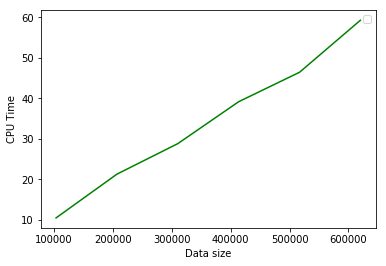

In [12]:
# Evolution du temps d'exécution
plt.plot(MS_max_samples_IF_Shuttle, MS_executions_time_IF_Shuttle, "g-")
#plt.title("CPU Time")
#plt.axis([0, 1, 0, 1])
plt.xlabel('Data size')
plt.ylabel('CPU Time')
plt.legend(loc="best")
    
plt.show()

No handles with labels found to put in legend.


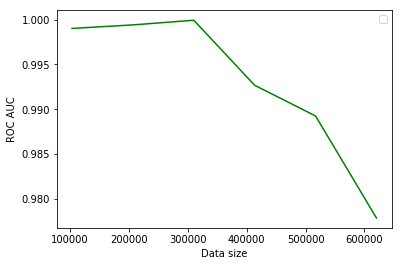

In [13]:
# Evolution de l'aire sous la courbe ROC
plt.plot(MS_max_samples_IF_Shuttle, MS_roc_auc_IF_Shuttle, "g-")
#plt.title("ROC AUC")
#plt.axis([0, 1, 0, 1])
plt.xlabel('Data size')
plt.ylabel('ROC AUC')
plt.legend(loc="best")
    
plt.show()

No handles with labels found to put in legend.


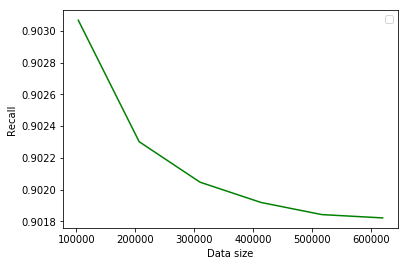

In [14]:
# Evolution du rappel
plt.plot(MS_max_samples_IF_Shuttle, MS_recalls_IF_Shuttle, "g-")
#plt.title("Rappel")
#plt.axis([0, 1, 0, 1])
plt.xlabel('Data size')
plt.ylabel('Recall')
plt.legend(loc="best")
    
plt.show()

No handles with labels found to put in legend.


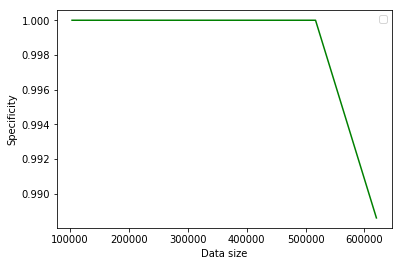

In [15]:
# Evolution de la spécificité
plt.plot(MS_max_samples_IF_Shuttle, MS_specificity_IF_Shuttle, "g-")
#plt.title("Specificité")
#plt.axis([0, 1, 0, 1])
plt.xlabel('Data size')
plt.ylabel('Specificity')
plt.legend(loc="best")
    
plt.show()

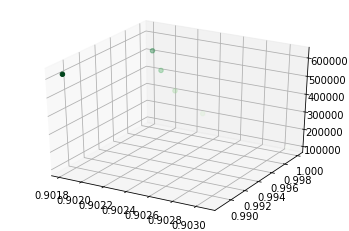

In [17]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(MS_recalls_IF_Shuttle, MS_specificity_IF_Shuttle, MS_max_samples_IF_Shuttle, c=MS_max_samples_IF_Shuttle, cmap='Greens')
